In [1]:
import numpy as np
import sep

The cell above is used to import libraries that do tasks. Sep is a library that estimates backgrounds, detects objects, and performs photometry. 

In [2]:
from astropy.io import fits
from astropy.utils.data import download_file

This imports Astropys FITS file reader which is used to open astronomy image files, and download_file imports a tool that downloads a file from the internet and saves it locally

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

importing the plotting library and plot configuration settings

In [4]:
rcParams['figure.figsize'] = [10., 8.]

Sets the default figure size for all plots to be 10 by 8 inches

In [5]:

url = 'https://github.com/sep-developers/sep/raw/refs/heads/main/data/image.fits'
local_path = download_file(url, cache=True)


stores the web address of thr FITS image and then downloads the file onto your computer and saves it locally

In [6]:

with fits.open(local_path, memmap=False) as hdul:
    data = hdul[0].data.astype(np.float32)


if not data.dtype.isnative:
    data = data.astype(data.dtype.newbyteorder('='))


ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


Opens the fits file and extracts the image matrix and converts it to 32 bit floating point numbers to then store it in data as a 2-D NumPy array using astropy

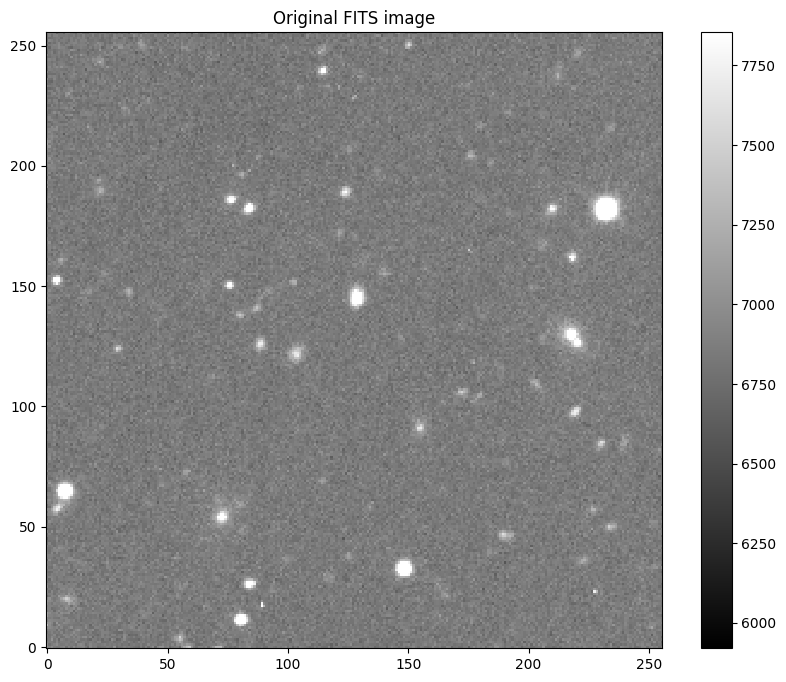

In [7]:


m, s = np.mean(data), np.std(data)
plt.figure()
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.title('Original FITS image')
plt.savefig('figure_1_original_image.png')
plt.show()



creates a blank plot that displays the image in grayscale with good contrast, correct orientation, labeled title, and saves it as a PNG

In [8]:
bkg = sep.Background(data) 

Creates a background model of the image

In [9]:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


prints the avergae background prightness and background noise level

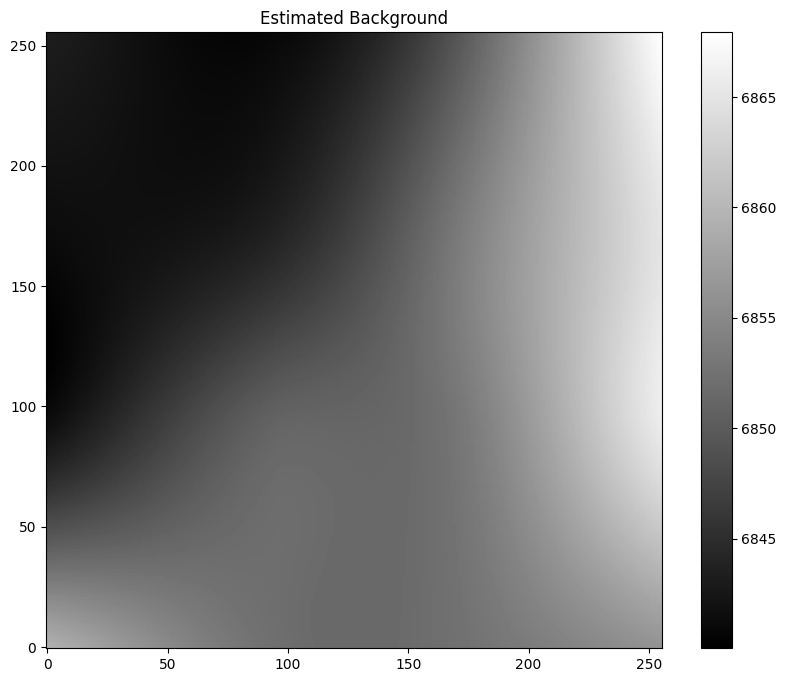

In [10]:

bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title('Estimated Background')
plt.savefig('figure_2_background.png')
plt.show()

creates and displays a 2D background image

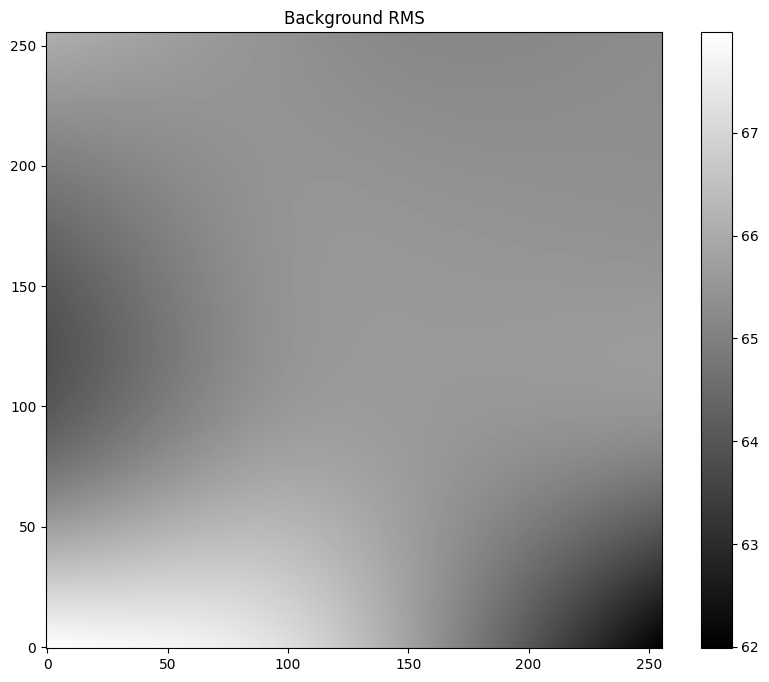

In [11]:

bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title('Background RMS')
plt.savefig('figure_3_background_rms.png')
plt.show()

Creates and displays the noise map of the image

In [12]:
data_sub = data - bkg

subtracts the background from the image so only the real objects are left

In [13]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
len(objects)

68

detects objects using a threshold of 1.5x noise and outputs how many objects were found

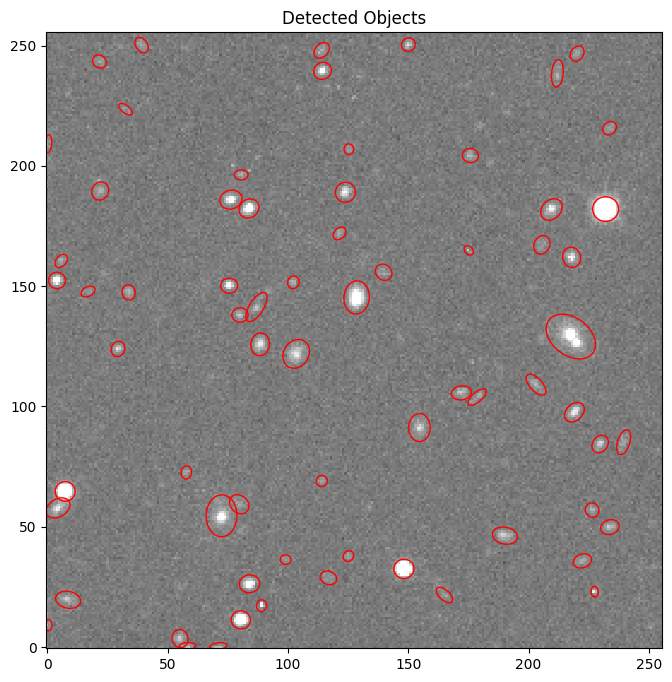

In [14]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.title('Detected Objects')
plt.savefig('figure_4_detected_objects.png')
plt.show()

Creates a loop through every detected object , sets ellipse center at the objects coordinates and makes it hollow and  to draw it on the image

In [15]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Lists all physical measurments returned for each object

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.157852 +/- 291.027799
object 1: flux = 3092.217500 +/- 291.592199
object 2: flux = 5949.861113 +/- 356.561993
object 3: flux = 1851.419824 +/- 295.028805
object 4: flux = 72736.380312 +/- 440.172199
object 5: flux = 3860.756895 +/- 352.163163
object 6: flux = 6418.902715 +/- 357.458957
object 7: flux = 2210.714238 +/- 350.791233
object 8: flux = 2741.609297 +/- 352.277749
object 9: flux = 20916.877363 +/- 376.966141


This measures the light intensity inside a 3-pixel radius around each object, loops it through the first 10 objects, then prints the object number, measured light, + photometry uncertainty.